Funkce ktera nam ulozi hodnoty do kolekce dictionary

In [32]:
import pandas as pd

out = 'data/csv/out_cle.csv'

# Cesta k nasim datum
csv_data = out

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')
# Odstraneni zbytecneho sloupce
df = df.drop(['Unnamed: 0'], axis = 1)

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])


In [33]:
# Funkce na "zplosteni" listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    for item in strings:
        if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
            flattened_list.append(item)
        else:  # Rekurzivne zavola sebe
            flattened_list.extend(flatten_list(item))
    return flattened_list

## Cisteni dat

In [34]:
import re
from collections import Counter
import numpy as np
 
# regex patern, ktery najde substring mezi zavorkami
pattern_cities = r"\((.*?)\)"

# Ulozime mesta do promenne
cities = df['magazine'].apply(lambda x: [re.search(pattern_cities, y).group(1) if re.search(pattern_cities, y) else None for y in x]).tolist().copy()

# Vytvorime zplostely list a odstranime None hodnoty
cities = sum(cities,[])

# Odstranime nenulove hodnoty
cities = list(filter(lambda x: x is not None, cities))

# Odstranime Index on Censorship z elementu "London, Index on Censorship"
cities = list(map(lambda x: 'London' if 'London' in x else x, cities))

# Odstranime 'Obstladen' z Winterthur
cities = list(map(lambda x: 'Winterthur' if 'Obstladen' in x else x, cities))

# Vytvorime dva elementy z New York-Paříž
cities = list(map(lambda x: ['New York','Paříž'] if 'New York-Paříž' in x else x, cities))

# Vytvorime dva elementy z New York-Paříž
cities = list(map(lambda x: ['Ženeva','Middlesex', 'Mnichov'] if 'Ženeva-Middlesex-Mnichov' in x else x, cities))

# Prepiseme Köln-Ehrenfeld na Kolín nad Rýnem 
cities = list(map(lambda x: 'Kolín nad Rýnem' if 'Köln-Ehrenfeld' in x else x, cities))

# Zplostime seznam
cities = flatten_list(cities)

print(Counter(cities))

Counter({'Mnichov': 2197, 'New York': 2090, 'Řím': 1484, 'Paříž': 928, 'Winterthur': 511, 'Hamburg': 428, 'Curych': 273, 'Toronto': 196, 'Rotterdam': 185, 'Wuppertal': 135, 'Kolín nad Rýnem': 120, 'Vídeň': 68, 'St. Gallen': 65, 'Ženeva': 53, 'Middlesex': 53, 'Londýn': 48, 'Edmonton': 39, 'Scheinfeld': 36, 'Norman, Oklahoma': 22, 'London': 17})


In [35]:
cities_number_of_records = Counter(cities)
cities_df = pd.DataFrame.from_dict(cities_number_of_records, orient='index').reset_index()
cities_df.columns = ['city', 'number of records']


print(cities_df)

                city  number of records
0             London                 17
1         Scheinfeld                 36
2            Mnichov               2197
3    Kolín nad Rýnem                120
4           New York               2090
5                Řím               1484
6             Curych                273
7         St. Gallen                 65
8              Vídeň                 68
9          Wuppertal                135
10            Londýn                 48
11           Hamburg                428
12  Norman, Oklahoma                 22
13            Ženeva                 53
14         Middlesex                 53
15             Paříž                928
16          Edmonton                 39
17           Toronto                196
18        Winterthur                511
19         Rotterdam                185


In [5]:
import requests

def get_city_coordinates(city):
    api_key = "MY KEY"
    url = f"https://api.opencagedata.com/geocode/v1/json?q={city}&key={api_key}"
    
    response = requests.get(url)
    data = response.json()
    
    if response.status_code == 200:
        if data["total_results"] > 0:
            lat = data["results"][0]["geometry"]["lat"]
            lon = data["results"][0]["geometry"]["lng"]
            return lat, lon
        else:
            print("No results found for the city.")
    else:
        print("Error occurred while fetching data.")

In [6]:
cities_df['latitude'] = None
cities_df['longitude'] = None
df.reindex(columns=['city', 'number of records', 'lat', 'lon'], fill_value=0)

unique_cities = set(cities)
coordinates = {}
for city in unique_cities:
    try:
        (latitude, longitude) = get_city_coordinates(city)
        print(f"Coordinates of {city}: Latitude={latitude}, Longitude={longitude}")
        coordinates[city] = (latitude, longitude)
        cities_df.loc[cities_df['city'] == city, 'latitude'] = latitude
        cities_df.loc[cities_df['city'] == city, 'longitude'] = longitude
    except:
        print(f"City {city} not found.")  

df_coordinates = pd.DataFrame.from_dict(coordinates)
df_coordinates.to_csv('data/coordinates.csv')

Error occurred while fetching data.
City Wuppertal not found.
Error occurred while fetching data.
City Norman, Oklahoma not found.
Error occurred while fetching data.
City Ženeva not found.
Error occurred while fetching data.
City Toronto not found.
Error occurred while fetching data.
City St. Gallen not found.
Error occurred while fetching data.
City Hamburg not found.
Error occurred while fetching data.
City London not found.
Error occurred while fetching data.
City Řím not found.
Error occurred while fetching data.
City Scheinfeld not found.
Error occurred while fetching data.
City Winterthur not found.
Error occurred while fetching data.
City Paříž not found.
Error occurred while fetching data.
City Middlesex not found.
Error occurred while fetching data.
City Vídeň not found.
Error occurred while fetching data.
City Kolín nad Rýnem not found.
Error occurred while fetching data.
City Rotterdam not found.
Error occurred while fetching data.
City Curych not found.
Error occurred whil

In [36]:
coordinates = pd.read_csv('data/coordinates.csv')
coordinates = coordinates.T
coordinates.columns = ['latitude', 'longitude']
coordinates['city'] = coordinates.index
df = pd.merge(cities_df, coordinates)

In [47]:
%pip install altair
%pip install vl-convert-python
%pip install altair_saver
import altair as alt
alt.data_transformers.disable_max_rows()

url = "https://raw.githubusercontent.com/deldersveld/topojson/master/world-continents.json"
source = alt.topo_feature(url, "continent")


base = alt.Chart(source).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    type = 'mercator',
#    scale= 350,                          # Magnify
#    center= [20,50],                     # [lon, lat]
#    clipExtent= [[0, 0], [400, 300]],    # [[left, top], [right, bottom]]
).properties(
    width=800,
    height=600
)

points = alt.Chart(df).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('number of records:Q', title='pocet clanku'),
    tooltip='city:N',
    color=alt.value('red')
)
base+points
combined_chart = base+points
combined_chart.save('plots/map.png')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


#### New approach

c:\Users\Panuskova\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<Figure size 1500x1000 with 0 Axes>

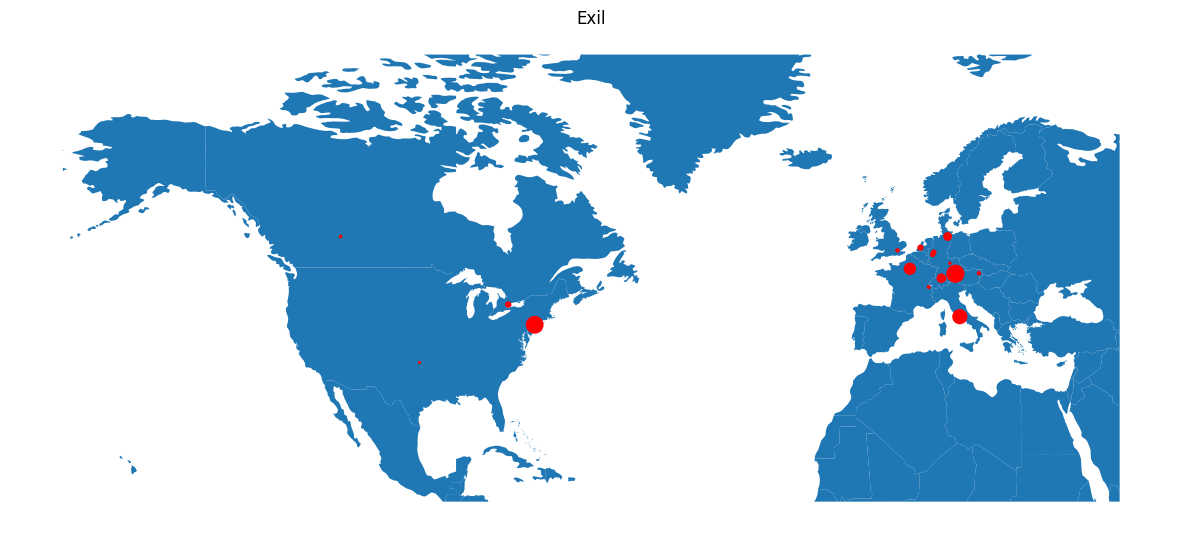

In [60]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

points_df = df.copy()
points_df['number of records'] = points_df['number of records'].apply(lambda x: x/15)  

# Convert the DataFrame to a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(points_df['longitude'], points_df['latitude'])]
points_gdf = gpd.GeoDataFrame(points_df, geometry=geometry, crs="EPSG:4326")

base_map_data = gpd.read_file("data/geojson/world_1960.geojson")

# Define the bounding box for Europe and North America
europe_and_north_america_bbox = [-170, 15, 45, 80]

# Set the size of the plot
plt.figure(figsize=(15,10))

# Crop the base map data to include only Europe and North America
ax = base_map_data.clip(europe_and_north_america_bbox).plot(figsize=(15,10))

#ax = europe_and_north_america_map_data.plot()
points_gdf.plot(figsize=(15,10),ax=ax, color = "red",column='number of records', markersize=points_gdf['number of records'])

plt.title("Exil")
plt.grid(False)
ax.set_axis_off()  # Turn off the axis to remove the axis frame
plt.savefig("plots/exil_cropped_map.png")
plt.show()



